In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
student_data <- read_delim(file = "https://raw.githubusercontent.com/czhang176/dsci100_groupproject/main/student-mat.csv", delim = ";") 
student_data

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
MS,M,21,R,GT3,T,1,1,other,other,⋯,5,5,3,3,3,3,3,10,8,7
MS,M,18,R,LE3,T,3,2,services,other,⋯,4,4,1,3,4,5,0,11,12,10
MS,M,19,U,LE3,T,1,1,other,at_home,⋯,3,2,3,3,3,5,5,8,9,9


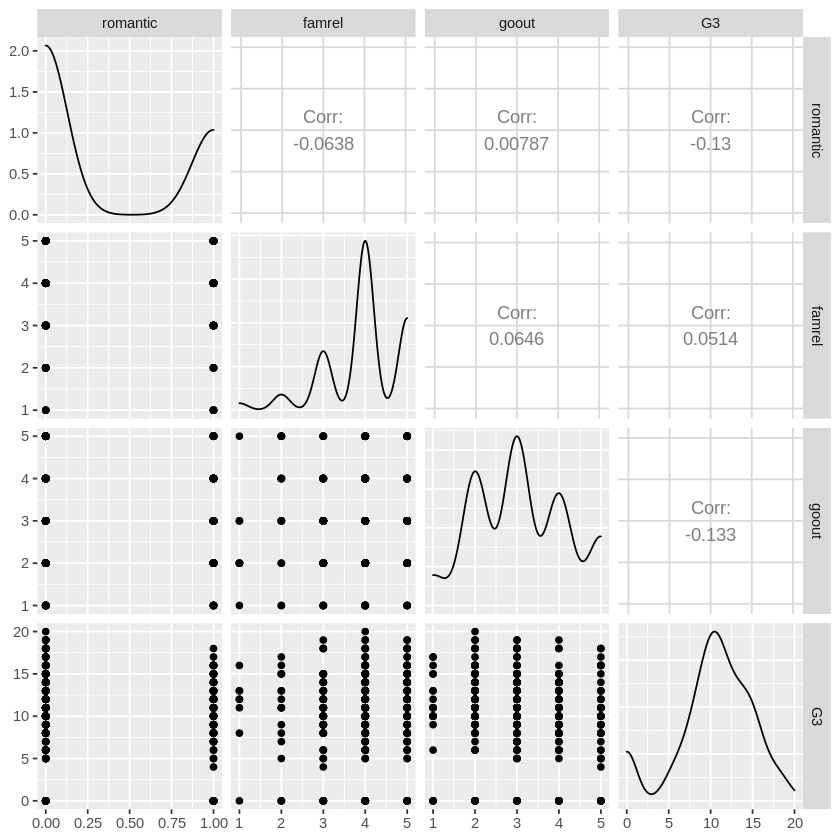

In [3]:
#visualize the correlation between social relationships 
plot_pairs <- student_data %>% mutate(romantic = nchar(romantic)-2) %>%
  select(romantic, famrel, goout, G3) %>%
  ggpairs()
plot_pairs

In [4]:
set.seed(1)
# select the lines we want, tidy data frame, group numerical G3 values by range 
student_data_1 <- student_data %>% 
                            select(goout, romantic, famrel, G3) %>% 
                            mutate(romantic = nchar(romantic)-2)%>% #change 'yes/no' to numeric value
                            mutate(grade = case_when(
                                           between(G3, 15, 20) ~ "excellent",
                                           between(G3, 10, 15) ~ "good",
                                           between(G3, 5, 10) ~ "bad",
                                           between(G3, 0, 5) ~ "fail",
                                           TRUE ~ NA_character_ )) %>% 
                            mutate(grade = as_factor(grade)) %>% 
                            select(goout, romantic, famrel, grade)
student_data_1


goout,romantic,famrel,grade
<dbl>,<dbl>,<dbl>,<fct>
4,0,4,bad
3,0,5,bad
2,0,4,good
⋮,⋮,⋮,⋮
3,0,5,bad
1,0,4,good
3,0,3,bad


In [5]:
# KNN CLASSIFICATION
# 1. Create the train / test split and Cross-validation data set
student_split <- initial_split(student_data_1, prop = 0.75, strata = grade)  
student_train <- training(student_split)   
student_test <- testing(student_split)

# 1.2 Create Cross-validation data set
student_vfold <- vfold_cv(student_train, v = 5, strata = grade)

# 2. Pre-process the data
student_recipe <- recipe(grade ~ ., data = student_train) %>% 
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# 3. Train the classifier
# 3.1 create the KNN model, set neighbours to tune
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# 3.2 tune w/ cross validation
gridvals <- tibble(neighbors = seq(1, 100))
student_knn_fit <- workflow() %>%
  add_recipe(student_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = student_vfold, grid = gridvals)

student_knn_result = student_knn_fit %>% collect_metrics()
student_knn_result

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3665804,5,0.029794617,Model001
1,roc_auc,hand_till,0.5223899,5,0.008752498,Model001
2,accuracy,multiclass,0.3836521,5,0.031732683,Model002
⋮,⋮,⋮,⋮,⋮,⋮,⋮
99,roc_auc,hand_till,0.5869032,5,0.012897872,Model099
100,accuracy,multiclass,0.4782855,5,0.002995519,Model100
100,roc_auc,hand_till,0.5870724,5,0.014517673,Model100


Now we will visualize the best parameters by graphing the accuracies against the K. 


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
37,accuracy,multiclass,0.4815642,5,0.003874104,Model037
57,accuracy,multiclass,0.4815642,5,0.003874104,Model057


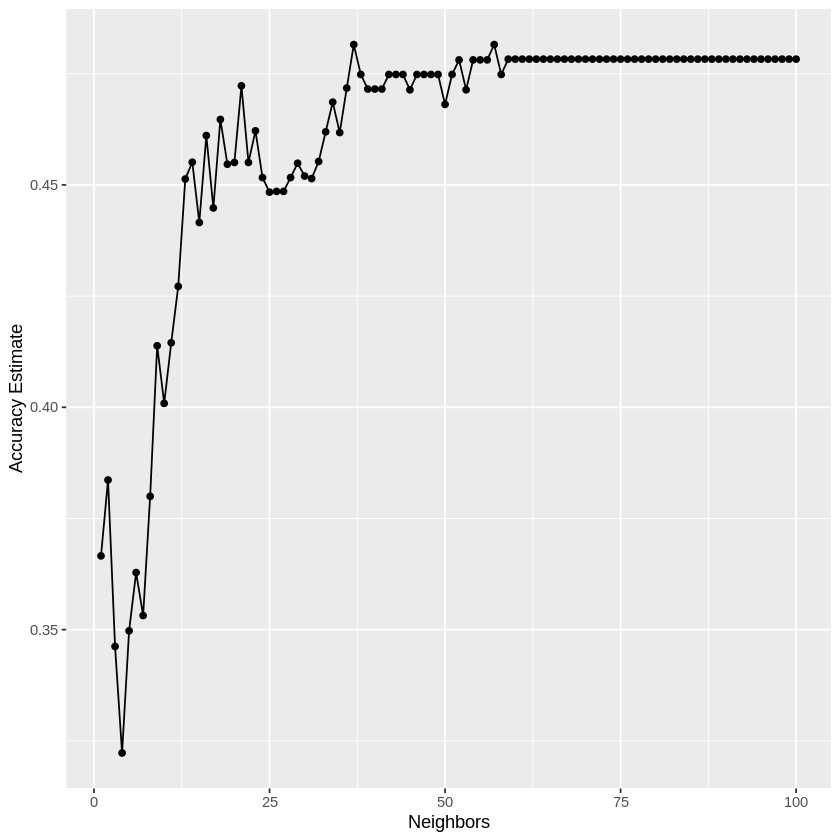

In [6]:
accuracies <- student_knn_result %>% 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") 
accuracy_versus_k

most_accurate <- accuracies %>% 
                    filter(.metric == "accuracy") %>% 
                    filter(mean == max(mean))
most_accurate

both parameters of k = 37 and k = 57 return a maximum accuracy. We will choose k = 37 to avoid overfitting

In [7]:
set.seed(1)
#create new model specification with k = 37 
knn_specc <- nearest_neighbor(weight_func = "rectangular", neighbors = 37) %>%
  set_engine("kknn") %>%
  set_mode("classification")

#re-train the classifier using parameters of k = 37
  knn_fit <- workflow() %>%
    add_recipe(student_recipe) %>%
    add_model(knn_specc) %>%
    fit(data = student_train)

#predict grades of testing data 
student_predictions <- predict(knn_fit, student_test) %>% 
                                bind_cols(student_test)
student_conf_mat <- student_predictions %>% 
                                    conf_mat(truth = grade, estimate = .pred_class)
student_conf_mat
print(student_predictions, n = 30)

           Truth
Prediction  bad good excellent fail
  bad         0    3         0    0
  good       24   47        17    7
  excellent   0    0         0    0
  fail        0    0         0    0

# A tibble: 98 x 5
   .pred_class goout romantic famrel grade    
   <fct>       <dbl>    <dbl>  <dbl> <fct>    
 1 good            3        0      5 bad      
 2 good            2        0      4 good     
 3 good            2        0      4 bad      
 4 good            1        0      4 excellent
 5 good            3        0      5 excellent
 6 bad             3        1      5 good     
 7 good            3        0      4 good     
 8 good            5        0      5 good     
 9 good            4        0      5 good     
10 good            4        1      5 good     
11 good            2        0      4 excellent
12 good            4        0      3 bad      
13 good            2        0      4 excellent
14 good            2        0      4 excellent
15 good            3        0      4 good     
16 bad             3        1      5 good     
17 good            1        0      4 good     
18 good            3        0      2 bad      
19 good            3        0      5 exce

As we can see- this classifier is bad. To see just how bad it is we will visualize the classifications of the Testing Data next to the predictions of the Testing Data. We will not include relationship status as an axis within our scatter plot because it is either yes or no (1 or 0). 

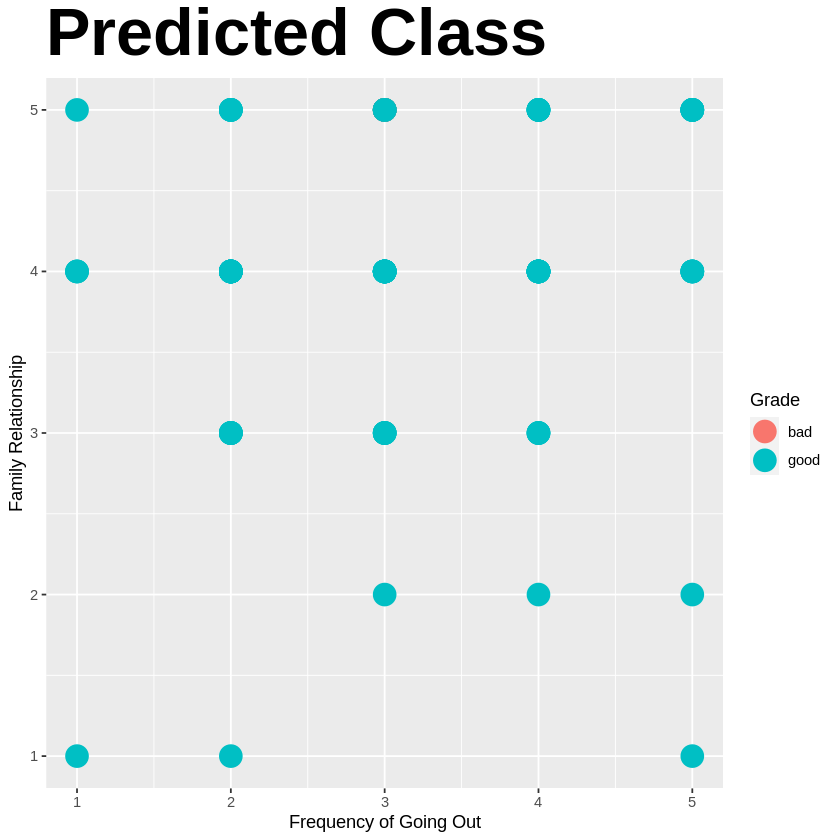

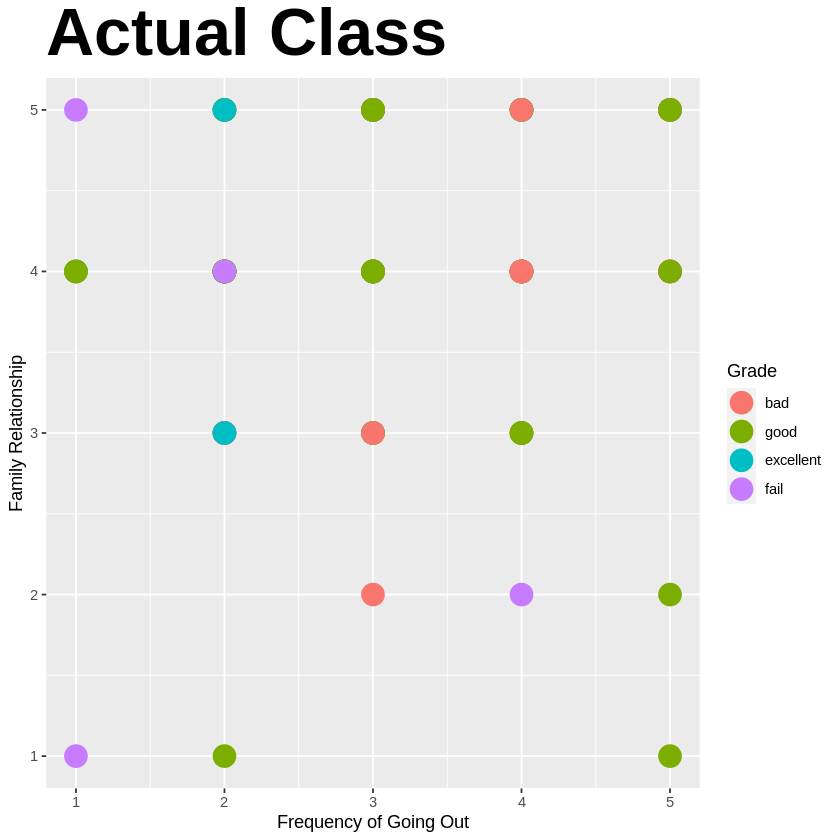

In [8]:
class_graph_pred <- student_predictions %>%
  ggplot(aes(x = goout, y = famrel, color = .pred_class)) +
  geom_point(size = 6) +
  labs(color = "Grade") +
  xlab("Frequency of Going Out") +
  ylab("Family Relationship")+
  ggtitle("Predicted Class") +
  theme(plot.title = element_text(size = 40, face = "bold"))
  
    
class_graph_pred

class_graph <- student_predictions %>%
                    ggplot(aes(x = goout, y = famrel, color = grade)) +
                      geom_point(size = 6) +
                      labs(color = "Grade") + 
                      xlab("Frequency of Going Out") +
                      ylab("Family Relationship") +
                      ggtitle("Actual Class")+
                      theme(plot.title = element_text(size = 40, face = "bold"))
class_graph

Here we can see that there has been an "averaging effect" with the data as the Predicted Class is almost all "good". In addition to this- our predictors may not be the best choice for final grade. We can see this in the Actual Class graph, as there is alot of variablity with few precise clusters based on grade. 